Final Exam: K Nearest Neighbors

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import pymysql
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import metrics
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Establish Connection
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='v7vsiuel',
                             db='cds695',
                             cursorclass=pymysql.cursors.DictCursor)
cursor = connection.cursor()

In [3]:

sql_query = """
SELECT
    institution.Institutions,
    companies_combined.FullName As Company_Name,
    countries.country AS Resident_Country,
    people.FullName

FROM people
    LEFT JOIN educationofeople on educationofeople.People_ID = people.Dir_ID
    LEFT JOIN institution on institution.Institutions_ID = educationofeople.Institutions_ID
    LEFT JOIN countries on countries.country_ID = people.Resident_Countr_ID
    LEFT JOIN peopleandcompanies on peopleandcompanies.People_ID = people.Dir_ID
    LEFT JOIN companies_combined on companies_combined.Company_ID = peopleandcompanies.Company_ID
"""


In [4]:
# Read Directors data from database using the following SQL query


# sql_query = """
# SELECT
#     education_title.title as Education_title,
#     institution.Institutions,
#     companies_combined.FullName As Company_Name,
#     countries.country AS Resident_Country,
#     peopleandcompanies.Role,
#     military_position.Rank,
#     military_branch.Branch,
#     people.FullName

# FROM people
#     LEFT JOIN militarystatus on militarystatus.People_ID = people.Dir_ID
#     LEFT JOIN military_position on military_position.Military_ID = militarystatus.Military_ID
#     LEFT JOIN military_branch on military_branch.Branch_ID = militarystatus.Branch_ID
#     LEFT JOIN educationofeople on educationofeople.People_ID = people.Dir_ID
#     LEFT JOIN institution on institution.Institutions_ID = educationofeople.Institutions_ID
#     LEFT JOIN education_title ON education_title.title_ID = educationofeople.educ_title_ID
#     LEFT JOIN countries on countries.country_ID = people.Resident_Countr_ID
#     LEFT JOIN peopleandcompanies on peopleandcompanies.People_ID = people.Dir_ID
#     LEFT JOIN companies_combined on companies_combined.Company_ID = peopleandcompanies.Company_ID

# """



df_directors = pd.read_sql(sql_query, connection)


col_names = df_directors.columns.tolist()

print("Directors data read successfully!")
print('Number of features: {}'.format(len(col_names)))
print('Shape of dataset: {}'.format(df_directors.shape))

Directors data read successfully!
Number of features: 4
Shape of dataset: (8184, 4)


In [5]:
# Examine features
print(df_directors.shape)
print(df_directors.isnull().sum()) # count the missing values in each column

# Replace missing values

# Drop a row if ANY values are missing, defaults to rows, but can be applied to columns with axis=1
df_directors.dropna(inplace=True)

print('***********************************************')
print(df_directors.shape)
print(df_directors.isnull().sum()) # count the missing values in each column

(8184, 4)
Institutions        6729
Company_Name        5004
Resident_Country    1881
FullName               0
dtype: int64
***********************************************
(1127, 4)
Institutions        0
Company_Name        0
Resident_Country    0
FullName            0
dtype: int64


In [6]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_directors = df_directors.index.size
n_features = df_directors.columns.size - 1
n_usa_residence = df_directors[df_directors['Resident_Country'] == 'USA\r' ].index.size
n_international_residence = n_directors - n_usa_residence
usa_rate = 100*float(n_usa_residence) / float(n_directors)
print("Total number of n_directors: {}".format(n_directors))
print("Number of n_directors who n_usa_residence: {}".format(n_usa_residence))
print("Number of n_directors who n_international_residence: {}".format(n_international_residence))
print("Number of features: {}".format(n_features))
print("Percentage of USA residence of the directors: {:.2f}%".format(usa_rate))

Total number of n_directors: 1127
Number of n_directors who n_usa_residence: 379
Number of n_directors who n_international_residence: 748
Number of features: 3
Percentage of USA residence of the directors: 33.63%


In [7]:
# Extract feature (X) and target (y) columns
feature_cols = list(df_directors.columns[:-1])  # all columns but last are features
target_col = df_directors.columns[-1]  # last column is the target/label
print("Feature column(s):-\n{}".format(feature_cols))
print("Target column: {}".format(target_col))

X_all = df_directors[feature_cols]  # feature values for all students
y_all = df_directors[target_col]  # corresponding targets/labels

Feature column(s):-
['Institutions', 'Company_Name', 'Resident_Country']
Target column: FullName


In [8]:
# Preprocess feature columns "Hot Encoding"
# Convert categorical variable into dummy/indicator variables
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'institution' => 'institution_harvard', 'institution_MS'
        outX = outX.join(col_data)  # collect column(s) in output dataframe
    return outX

X_all = preprocess_features(X_all)
# print("Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns)))

In [9]:
# First, decide how many training vs test samples you want
num_all = df_directors.shape[0] 
num_train = int(.75 * num_all)  # about 75% of the data
num_test = num_all - num_train

# Select features (X) and corresponding labels (y) for the training and test sets
# Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset

X_train, X_test, y_train, y_test = train_test_split( X_all , y_all , test_size = num_test, random_state=42)

print("Training set: {} samples".format(X_train.shape[0]))
print("Test set: {} samples".format(X_test.shape[0]))


Training set: 845 samples
Test set: 282 samples


In [10]:
# Train a model, Fit the model using X as training data and y as target values

def train_classifier(clf, X_train, y_train):
    #print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    #print "Training time (secs): {:.7f}".format(end - start)
    return end-start

In [11]:
# Predict the class labels for the provided data on training set and compute F1 score

'''Compute the F1 score, also known as balanced F-score or F-measure

The F1 score can be interpreted as a weighted average of the precision and recall, 
where an F1 score reaches its best value at 1 and worst score at 0. 
The relative contribution of precision and recall to the F1 score are equal. 

The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)'''

def predict_labels(clf, features, target):
    #print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    return f1_score(target.values, y_pred, pos_label=1, average='weighted'), end-start

In [12]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    #print "------------------------------------------"
    #print "Training set size: {}".format(len(X_train))
    training_time = train_classifier(clf, X_train, y_train)
    F1_train, pred_time_train = predict_labels(clf, X_train, y_train)
    F1_test, pred_time_test = predict_labels(clf, X_test, y_test)
    print("{:d} | {:5f} | {:5f} / {:5f} | {:5f} / {:5f} ".format(len(X_train) ,\
                                                                 training_time,\
                                                                 pred_time_train,\
                                                                 pred_time_test,\
                                                                 F1_train, F1_test ))

In [13]:
# Train and predict implementation
'''

JaccardDistance == number of non-equal dimensions / number of nonzero dimensions


((number of dims in which the first value is True, second is False) +
(number of dims in which the first value is False, second is True)) /

((number of dims in which the first value is True, second is False) +
(number of dims in which the first value is False, second is True) +
(number of dims in which both values are True))


'''
num_train_arr = [100,200,300]

knn_clf = KNeighborsClassifier(metric='jaccard')
clf_arr = [knn_clf]


for clf in clf_arr:
    print("Training {}...".format(clf.__class__.__name__))
    print('X_train_length | training_time / pred_time_train / pred_time_test | F1_train / F1_test')
    for num_train in num_train_arr:
        f1_dt = train_predict( clf , X_train[0:num_train], y_train[0:num_train], X_test, y_test )



Training KNeighborsClassifier...
X_train_length | training_time / pred_time_train / pred_time_test | F1_train / F1_test
100 | 0.001650 | 0.012139 / 0.030268 | 0.324912 / 0.093520 
200 | 0.001884 | 0.043599 / 0.061806 | 0.502690 / 0.270610 
300 | 0.004186 | 0.094445 / 0.082068 | 0.614627 / 0.432115 



The accuracy of the knn classifier for k = 3 is 79%

The optimal number of neighbors is 3.


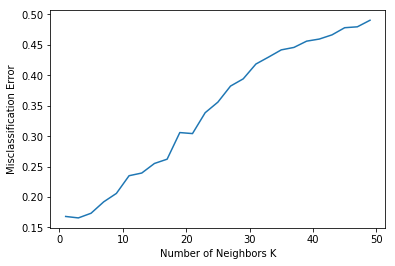

In [14]:

# ============================== KNN with k = 3 ===============================================
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = 3 is %d%%' % acc)


# ============================== parameter tuning =============================================
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(metric='jaccard', n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    '''
    
    In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

    A model is trained using k-1 of the folds as training data;
    the resulting model is validated on the remaining part of the data 
    (i.e., it is used as a test set to compute a performance measure such as accuracy).
    
    The performance measure reported by k-fold cross-validation is then the average of 
    the values computed in the loop. This approach can be computationally expensive, 
    but does not waste too much data (as it is the case when fixing an arbitrary test set), 
    which is a major advantage in problem such as inverse inference where the number of samples is very small.
    
    Accuracy classification score.
    In multilabel classification, this function computes subset accuracy: 
    the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
    '''
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [15]:
knn=KNeighborsClassifier(metric='jaccard', n_neighbors=100)
knn.fit(X_train,y_train)
pred = knn.predict(X_test[0:1])
print(pred)

['JOHN BERNARD ALEXEI ALEXANDER']
